In [129]:
# import packages

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [130]:
# define utility functions for accessing and plotting data

def get_metrics(experiment, model, output):

    filepath = f"../experiments/{experiment}/output/{model}/{output}/metrics.txt"

    metrics_dict = {}

    with open(filepath, 'r') as file:
        for line in file:
            key, value = line.strip().split(':')
            try:
                metrics_dict[key] = int(value)
            except ValueError:
                try:
                    metrics_dict[key] = float(value)
                except ValueError:
                    metrics_dict[key] = value

    return metrics_dict

def get_data(experiment, model, output):

    data = np.load(f"../experiments/{experiment}/output/{model}/{output}/generated_data.npy", allow_pickle=True)
    return data

def get_asym_data(asym):

    data = np.load(f"../datasets/data_input/gmm_dim_50_modes_2_asym_{asym}.npy", allow_pickle=True)
    return data

def create_output_loc_arr(variable, variable_arr, seed_arr):
    arr = np.array([])
    for var in variable_arr:
        for seed in seed_arr:
            arr = np.append(arr, f"{variable}={var}_seed={seed}")
    return arr

def FE_hist_mod(data, bounds, binw=0.1, binner=None):

    if binner is None:
        binner = (np.arange(bounds[0], bounds[1] + binw, binw),
                    np.arange(bounds[2], bounds[3] + binw, binw))

    counts, xedges, yedges = np.histogram2d(data[:,0], data[:,1],
                                           bins=binner, density=True)
    prob = counts + 1e-3
    G = -np.log(prob)
    G[G == np.inf] = -1
    G[G == -1] = max(G.ravel())
    G -= min(G.ravel())
    return G, prob, xedges, yedges

In [131]:
# example of KLD plot generation for one experiment, user may select different experiment for analysis by changing designated lines

# array indicating experimental variable [array -> user-chosen array]
modes_arr = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

seeds = [1, 2, 3]
bounds = np.array([-12, 12, -12, 12])

# accessor constructing output paths ['modes' -> user-chosen variable name]
modes_loc_arr = create_output_loc_arr('modes', modes_arr, seeds)

# accessor retrieving performance metric ['gmm_modes_paper' -> user-chosen experiment name, 'Final KLD' -> user-chosen metric]
cfm_KLD_raw = np.array([])
for loc in modes_loc_arr:
    cfm_KLD_raw = np.append(cfm_KLD_raw, get_metrics('gmm_modes', 'cfm', loc)['Final KLD'])

ddpm_KLD_raw = np.array([])
for loc in modes_loc_arr:
    ddpm_KLD_raw = np.append(ddpm_KLD_raw, get_metrics('gmm_modes', 'ddpm', loc)['Final KLD'])

ns_KLD_raw = np.array([])
for loc in modes_loc_arr:
    ns_KLD_raw = np.append(ns_KLD_raw, get_metrics('gmm_modes', 'ns', loc)['Final KLD'])

cfm_KLD_1 = cfm_KLD_raw[::3]
cfm_KLD_2 = cfm_KLD_raw[1::3]
cfm_KLD_3 = cfm_KLD_raw[2::3]

ddpm_KLD_1 = ddpm_KLD_raw[::3]
ddpm_KLD_2 = ddpm_KLD_raw[1::3]
ddpm_KLD_3 = ddpm_KLD_raw[2::3]

ns_KLD_1 = ns_KLD_raw[::3]
ns_KLD_2 = ns_KLD_raw[1::3]
ns_KLD_3 = ns_KLD_raw[2::3]

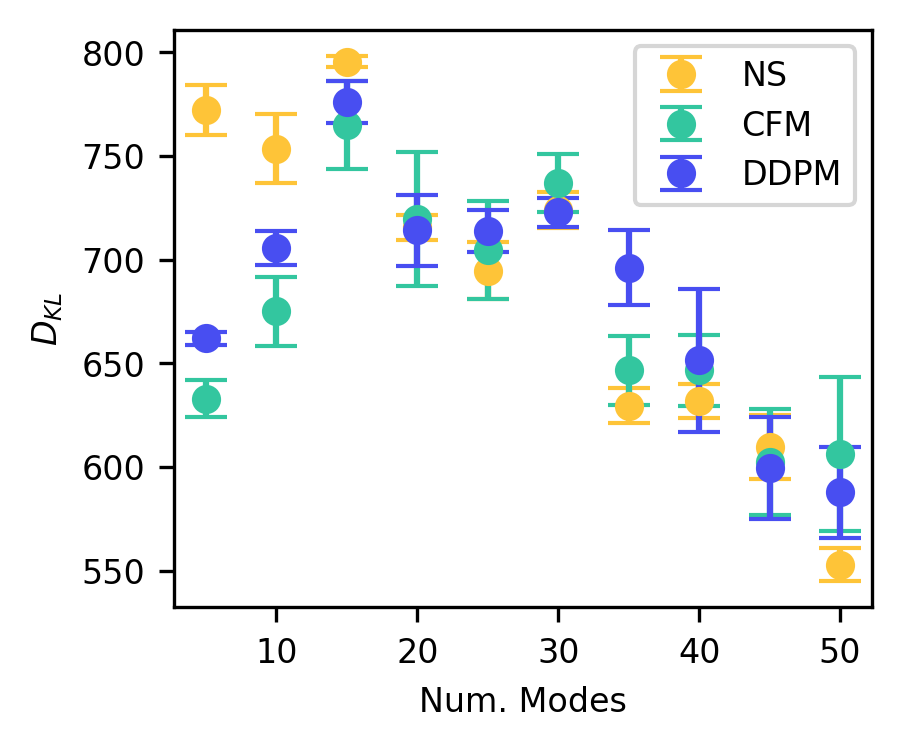

In [132]:
# plot KLD for the given experiment

plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(3, 2.5))

ns_all_arrays = np.array([ns_KLD_1, ns_KLD_2, ns_KLD_3])
cfm_all_arrays = np.array([cfm_KLD_1, cfm_KLD_2, cfm_KLD_3])
ddpm_all_arrays = np.array([ddpm_KLD_1, ddpm_KLD_2, ddpm_KLD_3])

ns_mean_KLD = np.mean(ns_all_arrays, axis=0)
ns_std_KLD = np.std(ns_all_arrays, axis=0)

cfm_mean_KLD = np.mean(cfm_all_arrays, axis=0)
cfm_std_KLD = np.std(cfm_all_arrays, axis=0)

ddpm_mean_KLD = np.mean(ddpm_all_arrays, axis=0)
ddpm_std_KLD = np.std(ddpm_all_arrays, axis=0)

plt.errorbar(modes_arr, ns_mean_KLD, yerr = ns_std_KLD, fmt='o', capsize=5, label='NS', color='#fec438')
plt.errorbar(modes_arr, cfm_mean_KLD, yerr = cfm_std_KLD, fmt='o', capsize=5, label='CFM', color='#33c69f')
plt.errorbar(modes_arr, ddpm_mean_KLD, yerr = ddpm_std_KLD, fmt='o', capsize=5, label='DDPM', color='#484ef1')

plt.xlabel("Num. Modes")
plt.ylabel(r"$D_{KL}$")

plt.legend()
plt.show()

In [133]:
# all results in the paper can be visualized by modifiying the above code to change the experiment and metric plotted,
# except for the asymmetry experiment, which requires a special integration step performed below

In [134]:
# instantiate needed asymmetry arrays

asym_arr = [0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.15, 0.25, 0.35, 0.5]
split_arr = [0.71, 0.7, 0.69, 0.685, 0.675, 0.67, 0.66, 0.575, 0.55, 0.5]
seeds = [1, 2, 3]
asym_loc_arr = create_output_loc_arr('asym', asym_arr, seeds)

In [135]:
# define asymmetry utility functions for integrating histogrammed distributions and computing free energy differences

def delta_from_hist(G, prob, xe, ye, split, cutoff):
    split_ind = int(split * G.shape[0])
    G_split1 = G[:split_ind, :]
    G_split2 = G[split_ind:, :]
    prob_split1 = prob[:split_ind, :]
    prob_split2 = prob[split_ind:, :]
    Z1 = np.sum(prob_split1 * np.where(G_split1 < cutoff, 1, 0))
    Z2 = np.sum(prob_split2 * np.where(G_split2 < cutoff, 1, 0))
    delta = np.abs(np.log(Z1) - np.log(Z2))
    return delta

def delta_models(asym, split, seed, cutoff):
    
    display_keyword = f'{asym}_varyingasym_{iter}'
    training_data = get_asym_data(asym)
    
    training_length = training_data.shape[0]
    ns_generated_data = get_data('gmm_asymmetry', 'ns', f'asym={asym}_seed={seed}')
    cfm_generated_data = get_data('gmm_asymmetry', 'cfm', f'asym={asym}_seed={seed}')
    ddpm_generated_data = get_data('gmm_asymmetry', 'ddpm', f'asym={asym}_seed={seed}')

    generated_length = ns_generated_data.shape[0]
    pca = PCA(n_components=2, svd_solver='randomized', random_state=1)
    training_pca = pca.fit_transform(training_data)
    ns_generated_pca = pca.transform(ns_generated_data)
    cfm_generated_pca = pca.transform(cfm_generated_data)
    ddpm_generated_pca = pca.transform(ddpm_generated_data)

    restrict = min(training_length, generated_length)

    G_MD, prob_MD, xe_MD, ye_MD = FE_hist_mod(training_pca[:restrict], bounds, binw=0.3)
    G_NS, prob_NS, xe_NS, ye_NS = FE_hist_mod(ns_generated_pca[:restrict], bounds, binw=0.3)
    G_CFM, prob_CFM, xe_CFM, ye_CFM = FE_hist_mod(cfm_generated_pca[:restrict], bounds, binw=0.3)
    G_DDPM, prob_DDPM, xe_DDPM, ye_DDPM = FE_hist_mod(ddpm_generated_pca[:restrict], bounds, binw=0.3)

    delta_arr = np.array([])

    delta_MD = delta_from_hist(G_MD, prob_MD, xe_MD, ye_MD, split, cutoff)
    delta_NS = delta_from_hist(G_NS, prob_NS, xe_NS, ye_NS, split, cutoff)
    delta_CFM = delta_from_hist(G_CFM, prob_CFM, xe_CFM, ye_CFM, split, cutoff)
    delta_DDPM = delta_from_hist(G_DDPM, prob_DDPM, xe_DDPM, ye_DDPM, split, cutoff)

    delta_arr = np.append(delta_arr, delta_MD)
    delta_arr = np.append(delta_arr, delta_NS)
    delta_arr = np.append(delta_arr, delta_CFM)
    delta_arr = np.append(delta_arr, delta_DDPM)
    
    return delta_arr

def models_plot(asym, split, seed, cutoff):
    
    display_keyword = f'{asym}_varyingasym_{iter}'
    training_data = get_asym_data(asym)
    
    training_length = training_data.shape[0]
    ns_generated_data = get_data('gmm_asymmetry', 'ns', f'asym={asym}_seed={seed}')
    cfm_generated_data = get_data('gmm_asymmetry', 'cfm', f'asym={asym}_seed={seed}')
    ddpm_generated_data = get_data('gmm_asymmetry', 'ddpm', f'asym={asym}_seed={seed}')

    generated_length = ns_generated_data.shape[0]
    pca = PCA(n_components=2, svd_solver='randomized', random_state=1)
    training_pca = pca.fit_transform(training_data)
    ns_generated_pca = pca.transform(ns_generated_data)
    cfm_generated_pca = pca.transform(cfm_generated_data)
    ddpm_generated_pca = pca.transform(ddpm_generated_data)

    restrict = min(training_length, generated_length)

    G_MD, prob_MD, xe_MD, ye_MD = FE_hist_mod(training_pca[:restrict], bounds, binw=0.3)
    G_NS, prob_NS, xe_NS, ye_NS = FE_hist_mod(ns_generated_pca[:restrict], bounds, binw=0.3)
    G_CFM, prob_CFM, xe_CFM, ye_CFM = FE_hist_mod(cfm_generated_pca[:restrict], bounds, binw=0.3)
    G_DDPM, prob_DDPM, xe_DDPM, ye_DDPM = FE_hist_mod(ddpm_generated_pca[:restrict], bounds, binw=0.3)
    
    return G_MD, xe_MD, ye_MD, G_NS, xe_NS, ye_NS, G_CFM, xe_CFM, ye_CFM, G_DDPM, xe_DDPM, ye_DDPM

In [136]:
# access raw generated data, histogram, and compute free energy differences for the asymmetry experiment

cutoff = 4.5
avoid_inf_index = 1 # may need to be manually adjusted

final_arr_1 = np.zeros((10, 4))
for i in np.arange(10):
    final_arr_1[i] = delta_models(asym_arr[i], split_arr[i], 1, cutoff)

final_arr_2 = np.zeros((10, 4))
for i in np.arange(10):
    final_arr_2[i] = delta_models(asym_arr[i], split_arr[i], 2, cutoff)

final_arr_3 = np.zeros((10, 4))
for i in np.arange(10):
    final_arr_3[i] = delta_models(asym_arr[i], split_arr[i], 3, cutoff)

train_fed_1 = final_arr_1[:,0]
train_fed_2 = final_arr_2[:,0]
train_fed_3 = final_arr_3[:,0]

ns_fed_1 = final_arr_1[:,1]
ns_fed_2 = final_arr_2[:,1]
ns_fed_3 = final_arr_3[:,1]

cfm_fed_1 = final_arr_1[:,2]
cfm_fed_2 = final_arr_2[:,2]
cfm_fed_3 = final_arr_3[:,2]

ddpm_fed_1 = final_arr_1[:,3]
ddpm_fed_2 = final_arr_2[:,3]
ddpm_fed_3 = final_arr_3[:,3]

train_fed_all_arrays = np.array([train_fed_1, train_fed_2, train_fed_3])[:,avoid_inf_index:]
ns_fed_all_arrays = np.array([ns_fed_1, ns_fed_2, ns_fed_3])[:,avoid_inf_index:]
cfm_fed_all_arrays = np.array([cfm_fed_1, cfm_fed_2, cfm_fed_3])[:,avoid_inf_index:]
ddpm_fed_all_arrays = np.array([ddpm_fed_1, ddpm_fed_2, ddpm_fed_3])[:,avoid_inf_index:]

/tmp/ipykernel_240063/4052717728.py:11: RuntimeWarning: divide by zero encountered in log
  delta = np.abs(np.log(Z1) - np.log(Z2))
/tmp/ipykernel_240063/4052717728.py:11: RuntimeWarning: divide by zero encountered in log
  delta = np.abs(np.log(Z1) - np.log(Z2))
/tmp/ipykernel_240063/4052717728.py:11: RuntimeWarning: divide by zero encountered in log
  delta = np.abs(np.log(Z1) - np.log(Z2))


In [137]:
# prepare asymmetry results for plotting, with R^2 values

ns_mean_fed = np.mean(ns_fed_all_arrays, axis=0)
ns_std_fed = np.std(ns_fed_all_arrays, axis=0)

cfm_mean_fed = np.mean(cfm_fed_all_arrays, axis=0)
cfm_std_fed = np.std(cfm_fed_all_arrays, axis=0)

ddpm_mean_fed = np.mean(ddpm_fed_all_arrays, axis=0)
ddpm_std_fed = np.std(ddpm_fed_all_arrays, axis=0)

train_mean_fed = np.mean(train_fed_all_arrays, axis=0)
train_std_fed = np.std(train_fed_all_arrays, axis=0)

ns_ss_res = np.sum((ns_fed_all_arrays - train_fed_all_arrays) ** 2)
ns_ss_tot = np.sum((ns_fed_all_arrays - np.mean(ns_fed_all_arrays)) ** 2)

cfm_ss_res = np.sum((cfm_fed_all_arrays - train_fed_all_arrays) ** 2)
cfm_ss_tot = np.sum((cfm_fed_all_arrays - np.mean(cfm_fed_all_arrays)) ** 2)

ddpm_ss_res = np.sum((ddpm_fed_all_arrays - train_fed_all_arrays) ** 2)
ddpm_ss_tot = np.sum((ddpm_fed_all_arrays - np.mean(ddpm_fed_all_arrays)) ** 2)

ns_rsq = 1 - ns_ss_res/ns_ss_tot
cfm_rsq = 1 - cfm_ss_res/cfm_ss_tot
ddpm_rsq = 1 - ddpm_ss_res/ddpm_ss_tot

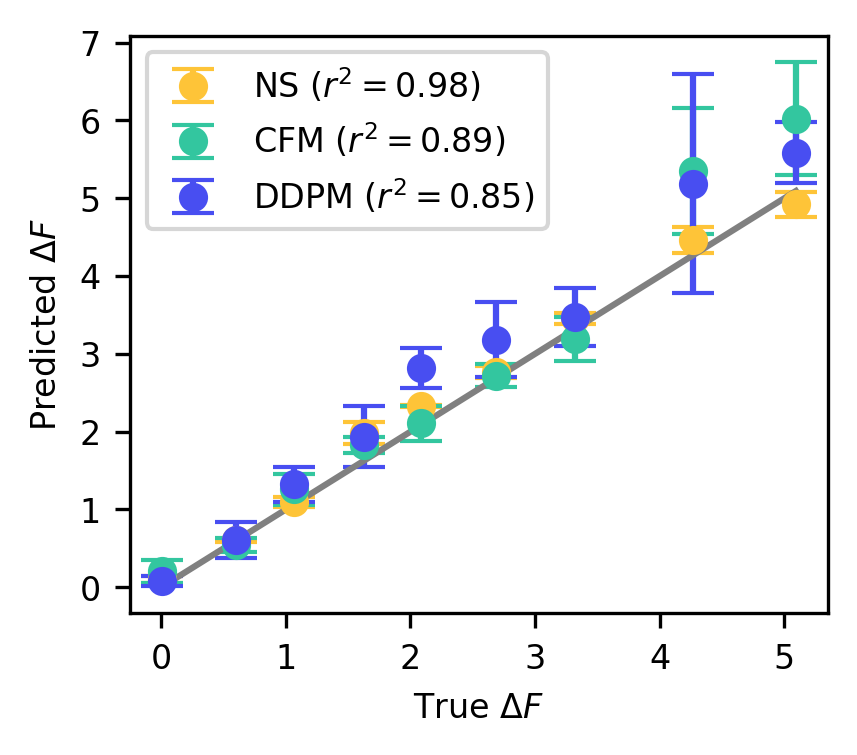

In [138]:
# plot asymmetry results

plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(3, 2.5))

plt.errorbar(train_mean_fed, ns_mean_fed, yerr = ns_std_fed, fmt='o', capsize=5, label=f"NS ($r^2={ns_rsq:.2f}$)", color='#fec438')
plt.errorbar(train_mean_fed, cfm_mean_fed, yerr = cfm_std_fed, fmt='o', capsize=5, label=f"CFM ($r^2={cfm_rsq:.2f}$)", color='#33c69f')
plt.errorbar(train_mean_fed, ddpm_mean_fed, yerr = ddpm_std_fed, fmt='o', capsize=5, label=f"DDPM ($r^2={ddpm_rsq:.2f}$)", color='#484ef1')
plt.plot(train_mean_fed, train_mean_fed, color='gray')

plt.xlabel(r"True $\Delta F$")
plt.ylabel(r"Predicted $\Delta F$")

plt.legend()

plt.show()

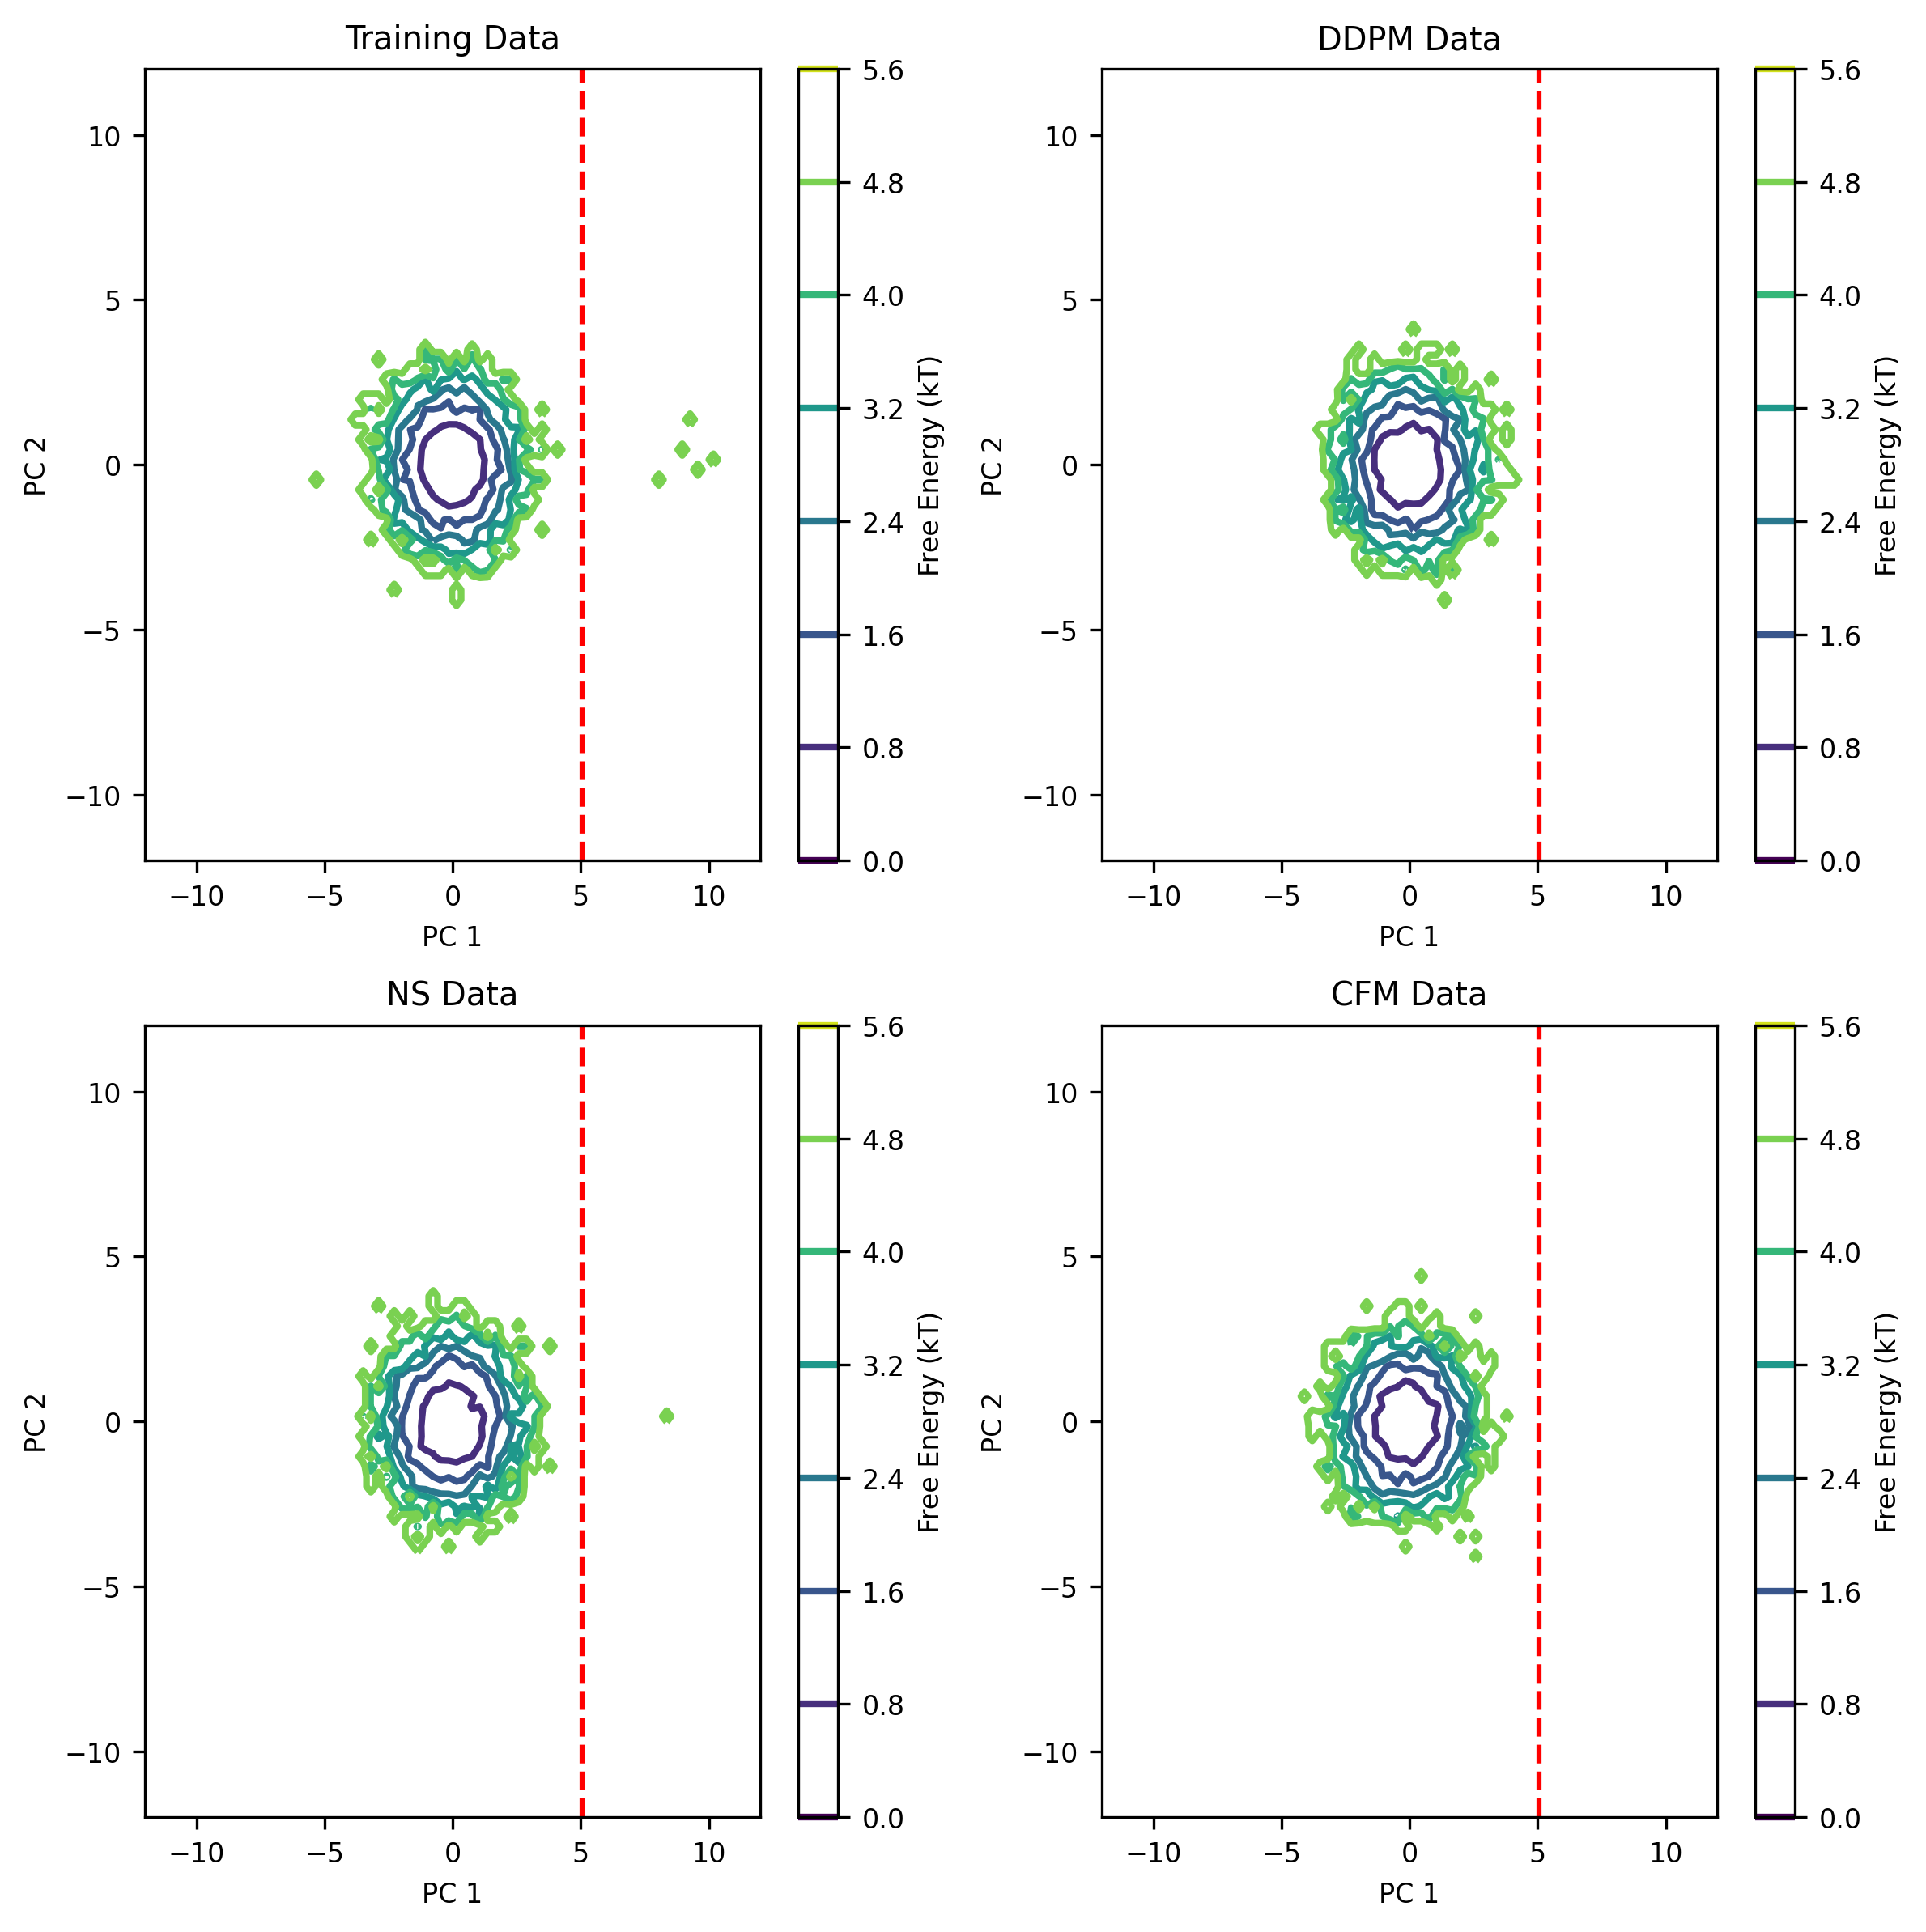

In [139]:
# visualize the generated data for the asymmetry experiment, as well as the boundary demarcating the two integration regions to compute FED

asym_visualizer_index = 0

G_MD, xe_MD, ye_MD, G_NS, xe_NS, ye_NS, G_CFM, xe_CFM, ye_CFM, G_DDPM, xe_DDPM, ye_DDPM = models_plot(asym_arr[asym_visualizer_index], split_arr[asym_visualizer_index], 1, 4.5)

fig, axs = plt.subplots(2,2, figsize=(8,8), dpi=300, tight_layout=False)
plt.rcParams.update({'font.size': 8})
for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=8)

line_val = bounds[0] + (bounds[1] - bounds[0]) * split_arr[asym_visualizer_index]

contour_MD = axs[0][0].contour(G_MD.T, extent=[xe_MD[0], xe_MD[-1], ye_MD[0], ye_MD[-1]],
                               linewidths=2, vmin=0, vmax=6)
contour_DDPM = axs[0][1].contour(G_DDPM.T, extent=[xe_DDPM[0], xe_DDPM[-1], ye_DDPM[0], ye_DDPM[-1]],
                                  linewidths=2, vmin=0, vmax=6)
contour_NS = axs[1][0].contour(G_NS.T, extent=[xe_NS[0], xe_NS[-1], ye_NS[0], ye_NS[-1]],
                                linewidths=2, vmin=0, vmax=6)
contour_CFM = axs[1][1].contour(G_CFM.T, extent=[xe_CFM[0], xe_CFM[-1], ye_CFM[0], ye_CFM[-1]],
                                 linewidths=2, vmin=0, vmax=6)

fig.colorbar(contour_MD, ax=axs[0][0], orientation='vertical', label='Free Energy (kT)')
fig.colorbar(contour_DDPM, ax=axs[0][1], orientation='vertical', label='Free Energy (kT)')
fig.colorbar(contour_NS, ax=axs[1][0], orientation='vertical', label='Free Energy (kT)')
fig.colorbar(contour_CFM, ax=axs[1][1], orientation='vertical', label='Free Energy (kT)')

axs[0][0].axvline(x=line_val, color='red', linestyle='--')
axs[0][1].axvline(x=line_val, color='red', linestyle='--')
axs[1][0].axvline(x=line_val, color='red', linestyle='--')
axs[1][1].axvline(x=line_val, color='red', linestyle='--')

axs[0][0].set_xlabel("PC 1")
axs[0][0].set_ylabel("PC 2")
axs[0][0].set_title("Training Data")
axs[0][1].set_xlabel("PC 1")
axs[0][1].set_ylabel("PC 2")
axs[0][1].set_title("DDPM Data")
axs[1][0].set_xlabel("PC 1")
axs[1][0].set_ylabel("PC 2")
axs[1][0].set_title("NS Data")
axs[1][1].set_xlabel("PC 1")
axs[1][1].set_ylabel("PC 2")
axs[1][1].set_title("CFM Data")

axs[0][0].set_xlim(bounds[0], bounds[1])
axs[0][0].set_ylim(bounds[2], bounds[3])
axs[0][1].set_xlim(bounds[0], bounds[1])
axs[0][1].set_ylim(bounds[2], bounds[3])

plt.show()